# Dataset

Link: https://www.kaggle.com/hugomathien/soccer

The domain of our database is highly related to “European Soccer” and the core tables are Players, Teams, Leagues and Matches. When designing the E-R model, we endow detailed attributes including several highly related entities, such as Injuries and Stadium, etc.


In [1]:
# Imports necessary modelus
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import sqlite3 # SQL, Sqlite file I/0
import matplotlib.pyplot as plt # Data Visualization plot
import datetime # Datetime type
import seaborn as sns # Data Visualization plot
import itertools
# Web Interface
from flask import Flask, request, render_template, url_for, redirect
# Data mining
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter("ignore")

# Input data files
path = ""  # Insert path here
database = path + 'database.sqlite'

In [2]:
# Build a connection
conn = sqlite3.connect(database)

# Read all tables in our sqlite file
tables = pd.read_sql("""
select *
from sqlite_master
where type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...
8,table,Stadium,Stadium,305673,"CREATE TABLE ""Stadium"" (\n""Confederation"" TEXT..."
9,table,Injury,Injury,306206,"CREATE TABLE ""Injury"" (\n""id"" TEXT,\n ""name"" ..."


In [3]:
# Integrate Soccer Injury Dataset
df = pd.read_csv("FootballStadiums.csv")
df.to_sql("Stadium", conn, if_exists='append', index=False)

In [4]:
# Integrate Soccer Injury Dataset
tuples = []
i=0
for t in open('Final-player.txt'):
    i=i+1
    if i == 2580:
        tuples.append(eval(t[1:-1]))
    else:
        tuples.append(eval(t[1:-2]))
df = pd.DataFrame(tuples)
df.columns = ["id", "name", "club","club_value","birth","weight","height","country","role","foot","transfers","injuries"]
number_of_players = df.shape[0]

In [5]:
# Currently each row is a player with a list of injuries , we will "flatten" it to get a row per injurie
s = df.apply(lambda x: pd.Series(x[11]),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'injurie'
df = df.drop(['injuries'], axis=1).join(s)
df.reset_index()
df = df.reset_index(drop=True)

In [6]:
# The injurie is currently describe as a tupple , we will create 3 new columns instead of injurie column:
# season of the injurie
# type of the injurie
# recovery time
df_injurie = pd.DataFrame(df['injurie'].tolist(), index=df.index)
df_injurie.head()
df = df.drop('injurie', axis=1).join(df_injurie)
df = df.rename(index=str, columns={0: "season", 1: "type" , 2 : "days"})
df.drop('transfers', axis=1, inplace=True)

In [7]:
# Now, check out on the tables we have 
Player_Attributes = pd.read_sql("""select * from Player_Attributes;""", conn)
Player = pd.read_sql("""select * from Player;""", conn)
Match = pd.read_sql("""select * from Match;""", conn)
League = pd.read_sql("""select * from League;""", conn)
Country = pd.read_sql("""select * from Country;""", conn)
Team = pd.read_sql("""select * from Team;""", conn)
Team_Attributes = pd.read_sql("""select * from Team_Attributes;""", conn)
Stadium = pd.read_sql("""select * from Stadium;""", conn)
Injury = pd.read_sql("""select * from Injury;""", conn)

In [8]:
Player_Attributes.head(1)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


In [9]:
Player.head(1)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187


In [10]:
Match.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.4,4.5,1.78,3.25,4.0,1.73,3.4,4.2


In [11]:
League.head(1)

,id,country_id,name
0,1,1,Belgium Jupiler League


In [12]:
Country.head(1)

,id,name
0,1,Belgium


In [13]:
Team.head(1)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN


In [14]:
Team_Attributes.head(1)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover


In [90]:
Stadium.head(1)

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population
0,UEFA,Stadiumi Besëlidhja,Lezhë,Besëlidhja,7000,Albania,ALB,2876591


In [92]:
Injury.head(1)

,id,player_name,club,club_value,birthday,weight,height,country,role,foot,season,type,days
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,16/17,Meniscal Injury,29


# SQL queries

In [17]:
# Query 1: Types of leagues
sql = pd.read_sql(""" select id,name from league
group by name
""", conn)
sql.head()

,id,name
0,1,Belgium Jupiler League
1,1729,England Premier League
2,4769,France Ligue 1
3,7809,Germany 1. Bundesliga
4,10257,Italy Serie A


In [18]:
# Query 2: League vs Country Name
sql = pd.read_sql(""" 
select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name""", conn)
sql.head()

,id,leagueName,countryName
0,1,Belgium Jupiler League,Belgium
1,1729,England Premier League,England
2,4769,France Ligue 1,France
3,7809,Germany 1. Bundesliga,Germany
4,10257,Italy Serie A,Italy


In [19]:
# Query 3: Teams associated with the leagues (Country vs League vs Teams)
sql = pd.read_sql(""" 
select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename

""", conn)
sql.head()

,countryName,LeagueName,TeamInTheLeague
0,Belgium,Belgium Jupiler League,Beerschot AC
1,Belgium,Belgium Jupiler League,Club Brugge KV
2,Belgium,Belgium Jupiler League,FCV Dender EH
3,Belgium,Belgium Jupiler League,KAA Gent
4,Belgium,Belgium Jupiler League,KAS Eupen


In [20]:
# Query 4: Player Information including rating and potential
sql = pd.read_sql(""" 
select 
pa.player_api_id as Player_api_id,
p.player_name as Player_Name, 
strftime('%d-%m-%Y',p.birthday) as DOB,
max(p.height) as Height,
max(p.weight) as Weight,
max(pa.overall_rating) as Rating,
max(pa.potential) as Potenital,
pa.preferred_foot as Preferred_Foot,
pa.attacking_work_rate as Attacking_Work_Rate,
pa.defensive_work_rate as Defensive_Work_Rate
from player p 
join player_attributes pa on p.player_api_id=pa.player_api_id and p.player_fifa_api_id=pa.player_fifa_api_id
group by p.player_name

""", conn)
sql.head()

,Player_api_id,Player_Name,DOB,Height,Weight,Rating,Potenital,Preferred_Foot,Attacking_Work_Rate,Defensive_Work_Rate
0,505942,Aaron Appindangoye,29-02-1992,182.88,187,67,71,right,medium,medium
1,155782,Aaron Cresswell,15-12-1989,170.18,146,74,80,left,medium,medium
2,162549,Aaron Doran,13-05-1991,170.18,163,71,78,right,medium,medium
3,30572,Aaron Galindo,08-05-1982,182.88,198,75,82,right,medium,high
4,23780,Aaron Hughes,08-11-1979,182.88,154,78,81,right,medium,medium


In [21]:
# Query 5: Home Team Information
sql = pd.read_sql(""" 
select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id
""", conn)
sql.head()

,match_api_id,home_team_api_id,team_long_name,team_short_name
0,483129,8583,AJ Auxerre,AUX
1,483130,9827,Girondins de Bordeaux,BOR
2,483131,9746,Le Havre AC,LEH
3,483132,8682,Le Mans FC,LEM
4,483133,9748,Olympique Lyonnais,LYO


In [22]:
# Query 6: Away Team Information
sql = pd.read_sql(""" 
select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id
""", conn)
sql.head()

,match_api_id,away_team_api_id,team_long_name,team_short_name
0,483129,9830,FC Nantes,NAN
1,483130,7819,SM Caen,CAE
2,483131,9831,OGC Nice,NIC
3,483132,8689,FC Lorient,LOR
4,483133,9941,Toulouse FC,TOU


In [23]:
# Query 7: Match Information with League, Season, Winner
sql = pd.read_sql(""" 
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_short_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_short_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id

""", conn)
sql.head()

,match_api_id,countryname,leaguename,Home_Team_Long_Name,Home_Team_Short_Name,Away_Team_Long_Name,Away_Team_Short_Name,season,Date,stage,home_team_goal,away_team_goal,Match_Winner
0,483129,France,France Ligue 1,AJ Auxerre,AUX,FC Nantes,NAN,2008/2009,09-08-2008,1,2,1,AUX
1,483130,France,France Ligue 1,Girondins de Bordeaux,BOR,SM Caen,CAE,2008/2009,09-08-2008,1,2,1,BOR
2,483131,France,France Ligue 1,Le Havre AC,LEH,OGC Nice,NIC,2008/2009,09-08-2008,1,1,0,LEH
3,483132,France,France Ligue 1,Le Mans FC,LEM,FC Lorient,LOR,2008/2009,09-08-2008,1,0,1,LOR
4,483133,France,France Ligue 1,Olympique Lyonnais,LYO,Toulouse FC,TOU,2008/2009,10-08-2008,1,3,0,LYO


In [24]:
# Query 8: Summary of each league for different seasons
sql = pd.read_sql("""
select Country.name as country_name, 
League.name as league_name, 
season,
count(distinct stage) as number_of_stages,
count(distinct HT.team_long_name) as number_of_teams,
avg(home_team_goal) as avg_home_team_scors, 
avg(away_team_goal) as avg_away_team_goals, 
avg(home_team_goal-away_team_goal) as avg_goal_dif, 
avg(home_team_goal+away_team_goal) as avg_goals, 
sum(home_team_goal+away_team_goal) as total_goals                                       
from Match
join Country on Country.id = Match.country_id
join League on League.id = Match.league_id
left join Team as HT on HT.team_api_id = Match.home_team_api_id
left join Team as AT on AT.team_api_id = Match.away_team_api_id
where country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
group by Country.name, League.name, season
having count(distinct stage) > 10
order by Country.name, League.name, season desc
;""", conn)
sql.head()

,country_name,league_name,season,number_of_stages,number_of_teams,avg_home_team_scors,avg_away_team_goals,avg_goal_dif,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
2,England,England Premier League,2013/2014,38,20,1.573684,1.194737,0.378947,2.768421,1052
3,England,England Premier League,2012/2013,38,20,1.557895,1.239474,0.318421,2.797368,1063
4,England,England Premier League,2011/2012,38,20,1.589474,1.215789,0.373684,2.805263,1066


In [25]:
# Query 9: Total Games played by team
sql = pd.read_sql(""" 
select 
ht.season as Season,
ht.team as Team ,
ht.home_games_played,
at.away_games_played,
ht.home_games_played + at.away_games_played as Total_games_played_for_the_season
from (
select b.season as Season,b.home_team_long_name as Team ,count(b.match_api_id) as home_games_played from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_short_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_short_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id ) b
group by b.season,b.home_team_long_name ) ht
join (select b.season as Season,b.away_team_long_name as team,count(b.match_api_id) as away_games_played from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_short_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_short_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id ) b
group by b.season,b.home_team_long_name) at on ht.season=at.season and ht.team=at.team
""", conn)
sql.head()

,Season,Team,home_games_played,away_games_played,Total_games_played_for_the_season
0,2008/2009,1. FC Köln,17,17,34
1,2008/2009,AC Bellinzona,18,18,36
2,2008/2009,ADO Den Haag,17,17,34
3,2008/2009,AJ Auxerre,19,19,38
4,2008/2009,AS Monaco,19,19,38


In [26]:
# Query 10: Matches won by Teams Season on Season
sql = pd.read_sql(""" 
select 
a.season,a.match_winner,count(a.match_winner) as Number_of_Wins
from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_long_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_long_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id) a
group by a.season,a.match_winner

""", conn)
sql.head()

,season,Match_Winner,Number_of_Wins
0,2008/2009,1. FC Köln,11
1,2008/2009,AC Bellinzona,11
2,2008/2009,ADO Den Haag,8
3,2008/2009,AJ Auxerre,16
4,2008/2009,AS Monaco,11


In [88]:
# Query 11: Most Successful Teams compared for all seasons based on Win_Percentage
sql = pd.read_sql(""" 
select * from (
select 
a.team,
sum(a.total_games),
sum(a.wins),
100*round(round(a.wins,2)/round(a.total_games,2),4) as Win_Percentage from
(select 
total_matches.season,
total_matches.team,
Total_games_played_for_the_season as total_games,
win_matches.number_of_wins as wins
from (
select 
ht.season as Season,
ht.team as Team ,
ht.home_games_played,
at.away_games_played,
ht.home_games_played + at.away_games_played as Total_games_played_for_the_season
from (
select b.season as Season,b.home_team_long_name as Team ,count(b.match_api_id) as home_games_played from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_short_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_short_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id ) b
group by b.season,b.home_team_long_name ) ht
join (select b.season as Season,b.away_team_long_name as team,count(b.match_api_id) as away_games_played from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_short_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_short_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id ) b
group by b.season,b.home_team_long_name) at on ht.season=at.season and ht.team=at.team ) total_matches join 
(select 
a.season,a.match_winner,count(a.match_winner) as Number_of_Wins
from (
select
a.match_api_id,
a.countryname,
a.leaguename,
ht.team_long_name as Home_Team_Long_Name,
ht.team_short_name as Home_Team_Short_Name,
at.team_long_name as Away_Team_Long_Name,
at.team_short_name as Away_Team_Short_Name,
a.season,
strftime('%d-%m-%Y',a.date) as Date,
a.stage,
a.home_team_goal,
a.away_team_goal,
case 
when a.home_team_goal - a.away_team_goal > 0 then ht.team_long_name
when a.home_team_goal - a.away_team_goal < 0 then at.team_long_name else 'Tie' end as Match_Winner
from (
select 
match_api_id,
country_team_league_table.countryname,
country_team_league_table.leaguename,
home_team_goal,
away_team_goal,
season,
date,
stage
from match m 
join team t on t.team_api_id=m.home_team_api_id or t.team_api_id=m.away_team_api_id
join (select 
country_league_table.countryname,
league_teams_table.LeagueName,
league_teams_table.Teamintheleague from (
select
l.name as LeagueName,
t.team_long_name as TeamInTheLeague
from league l 
join match m on l.country_id=m.country_id
join team t on  m.home_team_api_id=t.team_api_id
group by l.name,t.team_long_name) league_teams_table join (select c.id,
l.name as leagueName,
c.name as countryName
from league l
join country c on c.id=l.id
group by c.name,l.name) country_league_table on league_teams_table.leaguename=country_league_table.leaguename) country_team_league_table on t.team_long_name=country_team_league_table.teamintheleague
group by match_api_id ) a join (select  
match_api_id,
home_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.home_team_api_id
group by match_api_id) ht on a.match_api_id=ht.match_api_id 
join (select  
match_api_id,
away_team_api_id,
team_long_name,
team_short_name
from match m
join team t on t.team_api_id=m.away_team_api_id
group by match_api_id) at on a.match_api_id=at.match_api_id) a
group by a.season,a.match_winner) win_matches on total_matches.team=win_matches.match_winner) a
group by a.team)b
group by b.team
order by b.win_percentage desc
""", conn)
sql.head(10)

,team,sum(a.total_games),sum(a.wins),Win_Percentage
0,Manchester United,2432,1536,73.68
1,AZ,2176,1120,73.53
2,FC Barcelona,2432,1872,71.05
3,Standard de Liège,1484,742,70.59
4,RSC Anderlecht,1484,952,70.59
5,FC Porto,1984,1464,70.00
6,Rangers,608,432,68.42
7,Sporting CP,1984,1152,66.67
8,KV Oostende,108,58,66.67
9,FC Zürich,2288,960,66.67


In [28]:
# Left-Join Player with Injury with pandas function merge
Player['birthday'] = pd.to_datetime(Player['birthday'], format='%Y-%m-%d')
Injury['birth'] = pd.to_datetime(Injury['birth'], format='%Y-%m-%d')
Injury = Injury.rename(columns={"name":"player_name"})
Injury = Injury.rename(columns={"birth":"birthday"})
#Injury= Injury.drop(columns=['id','club','club_value','weight','height','country','foot'])
PlayerWithInjury=pd.merge(Player, Injury, on=['player_name','birthday'], how='left')
PlayerWithInjury=PlayerWithInjury.drop_duplicates()
PlayerWithInjury=PlayerWithInjury.dropna()
PlayerWithInjury.head()
# There are mutliple records for one player, since each player might has several injuries

,id_x,player_api_id,player_name,player_fifa_api_id,birthday,height_x,weight_x,id_y,club,club_value,weight_y,height_y,country,role,foot,season,type,days
1,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,92571,West Ham United,"323,00 Mill. €",66,"1,70",England,Defender - Left-Back,left,16/17,Groin Strain,11
2,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,92571,West Ham United,"323,00 Mill. €",66,"1,70",England,Defender - Left-Back,left,16/17,Knee Injury,84
26,8,30895,Aaron Lennon,152747,1987-04-16,165.10,139,14221,Burnley FC,"172,75 Mill. €",62,"1,65",England,Forward - Right Winger,right,17/18,Muscular problems,33
27,8,30895,Aaron Lennon,152747,1987-04-16,165.10,139,14221,Burnley FC,"172,75 Mill. €",62,"1,65",England,Forward - Right Winger,right,13/14,Foot Injury,53
28,8,30895,Aaron Lennon,152747,1987-04-16,165.10,139,14221,Burnley FC,"172,75 Mill. €",62,"1,65",England,Forward - Right Winger,right,12/13,Knee Injury,17


In [29]:
# Left-Join Team with Stadium with JOIN
TeamWithStadium = pd.read_sql("""
select distinct
A.*,
B.*
from Team A
join Stadium AS B
on A.team_long_name = B.HomeTeams;""",conn)
TeamWithStadium.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population
0,7,9991,674.0,KAA Gent,GEN,UEFA,Ghelamco Arena,Gent,KAA Gent,19999,Belgium,BEL,11420163
1,8,9998,1747.0,RAEC Mons,MON,UEFA,Stade Charles Tondreau,Mons,RAEC Mons,12662,Belgium,BEL,11420163
2,11,8203,110724.0,KV Mechelen,MEC,UEFA,AFAS Stadion,Mechelen,KV Mechelen,16672,Belgium,BEL,11420163
3,13,9999,546.0,KSV Roeselare,ROS,UEFA,Schierveldestadion,Roeselare,KSV Roeselare,9036,Belgium,BEL,11420163
4,17,10001,681.0,KVC Westerlo,WES,UEFA,t’Kuipje,Westerlo,KVC Westerlo,10278,Belgium,BEL,11420163


In [30]:
# Getting to see the top 20 matches (in number of gols scored) of the 2015/2016 Spanish League (La Liga) season

laliga_top20_2015_2016 = pd.read_sql("""
select 
A.*,
RESULT || ': ' || RESUME || ': ' || Home_Team_Name || ' ' || home_team_goal || ' x ' || away_team_goal || ' ' || Visitors_Team_Name AS RESUME_MATCH
from(
select  
X.stage,
DATE(X.date) as match_date,
X.home_team_goal,
X.away_team_goal,
X.home_team_goal + X.away_team_goal AS total_match_goals,
case
when X.home_team_goal = X.away_team_goal then 'DRAW'
when X.home_team_goal > X.away_team_goal then 'HOME WIN'
when X.home_team_goal < X.away_team_goal then 'VISITORS WIN'
end AS RESULT,
case
when abs(home_team_goal - away_team_goal) >= 3 then 'This game was a hammer!'
when abs(home_team_goal - away_team_goal) = 2 then 'A convincent win'
when abs(home_team_goal - away_team_goal) = 1 then 'Minimum Victory'
when (home_team_goal = away_team_goal) and home_team_goal > 0 then 'A draw with goals'
else 'A draw without goals'
end AS RESUME,
B.team_long_name as Home_Team_Name,
C.team_long_name as Visitors_Team_Name
from Match X
left join Team B
on X.home_team_api_id = B.team_api_id
left join Team C
on X.away_team_api_id = C.team_api_id
join Country Z
on X.country_id = Z.id
where X.season = '2015/2016'
and Z.name = 'Spain'  
) A
order by total_match_goals desc
limit 20;""", conn)
                                    
laliga_top20_2015_2016

,stage,match_date,home_team_goal,away_team_goal,total_match_goals,RESULT,RESUME,Home_Team_Name,Visitors_Team_Name,RESUME_MATCH
0,16,2015-12-20,10,2,12,HOME WIN,This game was a hammer!,Real Madrid CF,Rayo Vallecano,HOME WIN: This game was a hammer!: Real Madrid...
1,28,2016-03-05,7,1,8,HOME WIN,This game was a hammer!,Real Madrid CF,RC Celta de Vigo,HOME WIN: This game was a hammer!: Real Madrid...
2,34,2016-04-20,0,8,8,VISITORS WIN,This game was a hammer!,RC Deportivo de La Coruña,FC Barcelona,VISITORS WIN: This game was a hammer!: RC Depo...
3,20,2016-01-16,4,3,7,HOME WIN,Minimum Victory,RC Celta de Vigo,Levante UD,HOME WIN: Minimum Victory: RC Celta de Vigo 4 ...
4,21,2016-01-24,5,2,7,HOME WIN,This game was a hammer!,Athletic Club de Bilbao,SD Eibar,HOME WIN: This game was a hammer!: Athletic Cl...
5,24,2016-02-14,6,1,7,HOME WIN,This game was a hammer!,FC Barcelona,RC Celta de Vigo,HOME WIN: This game was a hammer!: FC Barcelon...
6,8,2015-10-17,5,2,7,HOME WIN,This game was a hammer!,FC Barcelona,Rayo Vallecano,HOME WIN: This game was a hammer!: FC Barcelon...
7,11,2015-11-07,1,5,6,VISITORS WIN,This game was a hammer!,RC Celta de Vigo,Valencia CF,VISITORS WIN: This game was a hammer!: RC Celt...
8,20,2016-01-17,6,0,6,HOME WIN,This game was a hammer!,FC Barcelona,Athletic Club de Bilbao,HOME WIN: This game was a hammer!: FC Barcelon...
9,20,2016-01-18,5,1,6,HOME WIN,This game was a hammer!,SD Eibar,Granada CF,HOME WIN: This game was a hammer!: SD Eibar 5 ...


# Data Mining & Data Visualization

# 1, Player Ranking (Finding best players each year)

In [31]:
# Player_api_id is not directly related with the team_api_id. 
# To relate them together we will use the Match Table.

In [32]:
Player.head(1)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187


In [33]:
Match.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.4,4.5,1.78,3.25,4.0,1.73,3.4,4.2


In [34]:
Team.head(1)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN


In [35]:
Player_Attributes.head(1)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


In [36]:
Team_Attributes.head(1)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover


In [37]:
# First step is to check NULL Data and taking filtering the fields that are being used

In [38]:
df_match = Match[['country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_player_1',
       'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5','home_player_6', 'home_player_7', 'home_player_8', 'home_player_9',
       'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2','away_player_3', 'away_player_4', 'away_player_5', 'away_player_6',
       'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10','away_player_11']]
df_match.isna().sum()

country_id             0
league_id              0
season                 0
stage                  0
date                   0
match_api_id           0
home_team_api_id       0
away_team_api_id       0
home_player_1       1224
home_player_2       1315
home_player_3       1281
home_player_4       1323
home_player_5       1316
home_player_6       1325
home_player_7       1227
home_player_8       1309
home_player_9       1273
home_player_10      1436
home_player_11      1555
away_player_1       1234
away_player_2       1278
away_player_3       1293
away_player_4       1321
away_player_5       1335
away_player_6       1313
away_player_7       1235
away_player_8       1341
away_player_9       1328
away_player_10      1441
away_player_11      1554
dtype: int64

In [39]:
df_team_attributes = Team_Attributes[['id', 'team_api_id', 'date']]
df_team_attributes.isna().sum()

id             0
team_api_id    0
date           0
dtype: int64

In [40]:
df_team = Team[['id', 'team_api_id', 'team_long_name']]
df_team.isna().sum()

id                0
team_api_id       0
team_long_name    0
dtype: int64

In [41]:
df_player = Player[['player_api_id', 'player_name' ]]
df_player.isna().sum()

player_api_id    0
player_name      0
dtype: int64

In [42]:
df_player_attributes = Player_Attributes[[ 'player_api_id', 'date', 'overall_rating','potential']]
df_player_attributes.isna().sum()

player_api_id       0
date                0
overall_rating    836
potential         836
dtype: int64

In [43]:
# As we will rating the player on the basis of overall_rating. 
# We will be dropping all the NULLs present in the overall_rating column from the DataFrame.
df_player_attributes = df_player_attributes.dropna()
df_player_attributes.isna().sum()

player_api_id     0
date              0
overall_rating    0
potential         0
dtype: int64

In [44]:
# Combining DataFrames to Have Player Name and Player attributes in a Single Data Frame
df_comb_player =  pd.merge(df_player, df_player_attributes, on="player_api_id")
df_comb_player['date'] = pd.to_datetime(df_comb_player['date'])
df_comb_player.head(1)

,player_api_id,player_name,date,overall_rating,potential
0,505942,Aaron Appindangoye,2016-02-18,67.0,71.0


## How we rank players:
 1) Filtering the players by year (2010-2016)  
 2) Taking the last updated intance of the player attributes of that year  
 3) Sorting the Players by overall_rating column, if overall_rating for any two player is same we will consider the potential column.  
 4) Returning the top 10 values from the sorted DataFrame.

In [45]:
def top_N_players(df,year,n=10):
    """Function which return N Number of Top Player at end of Year"""
    df_top = df[df['date'].dt.year == year]
    df_top = df_top.sort_values('date').groupby('player_api_id').last() # Taking only last instance
    df_top = df_top.sort_values(['overall_rating','potential']).tail(n)
    df_top = df_top.sort_values(['overall_rating','potential'],ascending=False)
    return df_top

In [46]:
# Year 2016
df = top_N_players(df_comb_player,2016)[['player_name','overall_rating','potential']]
df.reset_index(level=0, inplace=True)
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank1"},inplace=True)
df_rank =df[:5]
df

,rank1,player_api_id,player_name,overall_rating,potential
0,1,19533,Neymar,90.0,94.0
1,2,27299,Manuel Neuer,90.0,90.0
2,3,30834,Arjen Robben,89.0,89.0
3,4,107417,Eden Hazard,88.0,90.0
4,5,36378,Mesut Oezil,88.0,89.0
5,6,93447,Robert Lewandowski,88.0,89.0
6,7,37412,Sergio Aguero,88.0,88.0
7,8,164684,James Rodriguez,87.0,93.0
8,9,182917,David De Gea,87.0,90.0
9,10,95078,Toni Kroos,87.0,89.0


In [47]:
# Year 2015
df = top_N_players(df_comb_player,2015)[['player_name','overall_rating','potential']]
df.reset_index(level=0, inplace=True)
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank2"},inplace=True)
df_rank = pd.merge(df_rank,df[:5],on=["player_api_id","player_name"],how='outer')
df

,rank2,player_api_id,player_name,overall_rating,potential
0,1,30981,Lionel Messi,94.0,94.0
1,2,30893,Cristiano Ronaldo,93.0,93.0
2,3,27299,Manuel Neuer,90.0,90.0
3,4,30834,Arjen Robben,90.0,90.0
4,5,40636,Luis Suarez,90.0,90.0
5,6,19533,Neymar,89.0,94.0
6,7,107417,Eden Hazard,89.0,91.0
7,8,35724,Zlatan Ibrahimovic,89.0,89.0
8,9,37459,David Silva,88.0,88.0
9,10,80562,Thiago Silva,88.0,88.0


In [48]:
# Year 2014
df = top_N_players(df_comb_player,2014)[['player_name','overall_rating','potential']]
df.reset_index(level=0, inplace=True)
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank3"},inplace=True)
df_rank = pd.merge(df_rank,df[:5],on=["player_api_id","player_name"],how='outer')
df

,rank3,player_api_id,player_name,overall_rating,potential
0,1,30981,Lionel Messi,93.0,95.0
1,2,30893,Cristiano Ronaldo,92.0,92.0
2,3,27299,Manuel Neuer,90.0,90.0
3,4,30834,Arjen Robben,90.0,90.0
4,5,35724,Zlatan Ibrahimovic,90.0,90.0
5,6,40636,Luis Suarez,89.0,91.0
6,7,30955,Andres Iniesta,89.0,89.0
7,8,107417,Eden Hazard,88.0,90.0
8,9,30872,Bastian Schweinsteiger,88.0,88.0
9,10,30924,Franck Ribery,88.0,88.0


In [49]:
# Year 2013
df = top_N_players(df_comb_player,2013)[['player_name','overall_rating','potential']]
df.reset_index(level=0, inplace=True)
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank4"},inplace=True)
df_rank = pd.merge(df_rank,df[:5],on=["player_api_id","player_name"],how='outer')
df

,rank4,player_api_id,player_name,overall_rating,potential
0,1,30981,Lionel Messi,94.0,97.0
1,2,30893,Cristiano Ronaldo,92.0,95.0
2,3,22543,Radamel Falcao,90.0,92.0
3,4,30924,Franck Ribery,90.0,90.0
4,5,30955,Andres Iniesta,89.0,91.0
5,6,30843,Robin van Persie,89.0,89.0
6,7,35724,Zlatan Ibrahimovic,89.0,89.0
7,8,39854,Xavi Hernandez,89.0,89.0
8,9,30872,Bastian Schweinsteiger,88.0,88.0
9,10,80562,Thiago Silva,88.0,88.0


In [50]:
# Year 2012
df = top_N_players(df_comb_player,2012)[['player_name','overall_rating','potential']]
df.reset_index(level=0, inplace=True)
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank5"},inplace=True)
df_rank = pd.merge(df_rank,df[:5],on=["player_api_id","player_name"],how='outer')
df

,rank5,player_api_id,player_name,overall_rating,potential
0,1,30981,Lionel Messi,94.0,96.0
1,2,30893,Cristiano Ronaldo,92.0,94.0
2,3,30955,Andres Iniesta,90.0,93.0
3,4,30924,Franck Ribery,90.0,90.0
4,5,39854,Xavi Hernandez,90.0,90.0
5,6,30829,Wayne Rooney,89.0,92.0
6,7,30657,Iker Casillas,89.0,90.0
7,8,30865,Nemanja Vidic,89.0,89.0
8,9,37459,David Silva,88.0,91.0
9,10,30834,Arjen Robben,88.0,90.0


In [51]:
# Year 2011
df = top_N_players(df_comb_player,2011)[['player_name','overall_rating','potential']]
df.reset_index(level=0, inplace=True)
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank6"},inplace=True)
df_rank = pd.merge(df_rank,df[:5],on=["player_api_id","player_name"],how='outer')
df

,rank6,player_api_id,player_name,overall_rating,potential
0,1,30981,Lionel Messi,94.0,96.0
1,2,30893,Cristiano Ronaldo,92.0,94.0
2,3,39854,Xavi Hernandez,92.0,92.0
3,4,30955,Andres Iniesta,91.0,93.0
4,5,30829,Wayne Rooney,90.0,92.0
5,6,30834,Arjen Robben,90.0,91.0
6,7,30657,Iker Casillas,89.0,92.0
7,8,30865,Nemanja Vidic,89.0,91.0
8,9,37482,Gerard Pique,88.0,91.0
9,10,30878,Wesley Sneijder,88.0,90.0


In [52]:
# Year 2010
df = top_N_players(df_comb_player,2010)[['player_name','overall_rating','potential']]
df.reset_index(level=0, inplace=True)
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank7"},inplace=True)
df_rank = pd.merge(df_rank,df[:5],on=["player_api_id","player_name"],how='outer')
df

,rank7,player_api_id,player_name,overall_rating,potential
0,1,30981,Lionel Messi,90.0,95.0
1,2,30893,Cristiano Ronaldo,89.0,94.0
2,3,30657,Iker Casillas,89.0,92.0
3,4,30909,David Villa,88.0,92.0
4,5,30829,Wayne Rooney,88.0,91.0
5,6,30822,Didier Drogba,88.0,90.0
6,7,30661,Carles Puyol,87.0,90.0
7,8,30865,Nemanja Vidic,87.0,90.0
8,9,30955,Andres Iniesta,87.0,90.0
9,10,39854,Xavi Hernandez,87.0,90.0


In [53]:
# Making a Line Plot of top 10 Players
df_rank.index = df_rank.player_name
# Taking only the rank in consideration
df_rank = df_rank[[ 'rank1', 'rank2','rank3', 'rank4', 'rank5', 'rank6', 'rank7']]

In [54]:
df_rank = df_rank.replace(np.NaN,6) # Replacing the NaNs with 11 to better represent the graph
df_rank['sum_rank'] = df_rank[[ 'rank1', 'rank2','rank3', 'rank4', 'rank5', 'rank6', 'rank7']].sum(axis=1)

In [55]:
df_rank =  df_rank.sort_values('sum_rank').head(10) # Sorting and taking only top 10 values 
thickness = df_rank.sum_rank
df_rank  = df_rank.drop('sum_rank',axis=1)
df1_transposed = df_rank.T

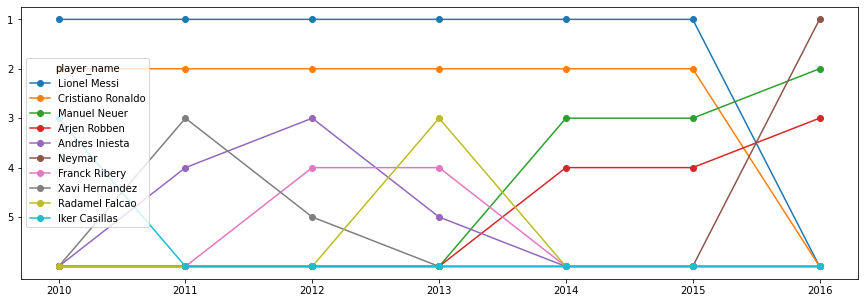

In [56]:
df1_transposed.plot(kind='line',figsize=(15,5), marker='o')
plt.gca().invert_yaxis() # Inverting y axis
plt.gca().invert_xaxis() # Inverting y axis
plt.yticks(range(1,6))
ind = np.arange(7) 
plt.xticks(ind, ("2016","2015","2014","2013","2012","2011","2010"))
plt.show();

# 2, Team Ranking (Finding best teams each year)

# How we rank teams:
 1) Filtering the players by year  
 2) Taking the last updated intance of the player attributes of that year  
 3) Making a Table to map team_api_id to player_api_id  
 4) Merging the player_api_id with team_api_id  
 5) Grouping by team_api_id and summing the top 15 players of that team.  
 6) Sorting the grouped values and returning the top 5 teams by total rating.

In [57]:
# Merge Team and Team Attribute Tables
df_comb_team = pd.merge(df_team, df_team_attributes, on="team_api_id")
df_comb_team['date'] = pd.to_datetime(df_comb_team['date'])
df_comb_team.head(1)

,id_x,team_api_id,team_long_name,id_y,date
0,1,9987,KRC Genk,485,2010-02-22


In [58]:
# Just check on
df_comb_team_2015 = df_comb_team[df_comb_team['date'].dt.year == 2015]
df_comb_team_2015 = df_comb_team_2015.sort_values('date').groupby('team_api_id').last()
df_comb_team_2015.head()

,id_x,team_long_name,id_y,date
team_api_id,,,,
1601,31446,Ruch Chorzów,1118,2015-09-10
1957,31456,Jagiellonia Białystok,624,2015-09-10
2182,31453,Lech Poznań,700,2015-09-10
2186,31458,Cracovia,335,2015-09-10
4087,11822,Évian Thonon Gaillard FC,415,2015-09-10


In [59]:
# Making the fuctions for usage

def end_of_year_player(df_comb_player,year):
    df_comb_player['date'] = pd.to_datetime(df_comb_player['date'])
    df_comb_player = df_comb_player[df_comb_player['date'].dt.year == year]
    df_comb_player = df_comb_player.sort_values('date').groupby('player_api_id').last()    
    df_comb_player.reset_index(level=0, inplace=True)
    return df_comb_player[['player_api_id','player_name', 'date', 'overall_rating', 'potential']]


def end_of_year_team(df_comb_team):
    df_comb_team = df_comb_team.sort_values('date').groupby('team_api_id').last()
    df_comb_team.reset_index(level=0, inplace=True)
    return df_comb_team[['team_api_id','team_long_name','date']]


def team_to_player_home(df_match,year):
    players_list_home = ['date','home_team_api_id','home_player_1', 'home_player_2', 'home_player_3',
   'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
   'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11']
    df_match = df_match.loc[:,players_list_home]
    df_match['date'] = pd.to_datetime(df_match['date'])
    df_match = df_match[df_match['date'].dt.year == year]
    df_match = df_match.drop(['date'],axis=1)
    df_team_to_player=df_match.melt(['home_team_api_id']).sort_values('home_team_api_id')
    df_team_to_player = df_team_to_player[["home_team_api_id","value"]]
    df_team_to_player.rename( columns={"value":"player_api_id", "home_team_api_id":"team_api_id" },inplace=True)
    df_team_to_player = df_team_to_player.drop_duplicates()
    df_team_to_player = df_team_to_player.dropna()
    return df_team_to_player

def team_to_player_away(df_match,year):
    players_list_away = [ 'date','away_team_api_id','away_player_1', 'away_player_2','away_player_3', 'away_player_4', 'away_player_5', 'away_player_6',
       'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10','away_player_11']
    df_match = df_match.loc[:,players_list_away]
    df_match['date'] = pd.to_datetime(df_match['date'])
    df_match = df_match[df_match['date'].dt.year == year]
    df_match = df_match.drop(['date'],axis=1)
    df_team_to_player=df_match.melt(['away_team_api_id']).sort_values('away_team_api_id')
    df_team_to_player = df_team_to_player[["away_team_api_id","value"]]
    df_team_to_player.rename( columns={"value":"player_api_id", "away_team_api_id":"team_api_id" },inplace=True)
    df_team_to_player = df_team_to_player.drop_duplicates()
    df_team_to_player = df_team_to_player.dropna()
    return df_team_to_player

def team_to_player(df_match,year):    
    df_2 = team_to_player_home(df_match,year)
    df_1 = team_to_player_away(df_match,year)
    df_combined = [df_1,df_2]
    result = pd.concat(df_combined)
    result = result.drop_duplicates()
    return result
    
def top_N_team(df_comb_team,df_comb_player,df_match,season="2015/2016",n=5):
    year = int(season.split("/")[0])
    df_end_of_year_team = end_of_year_team(df_comb_team)
    df_end_of_year_player = end_of_year_player(df_comb_player,year)
    df_team_to_player = team_to_player(df_match,year)
    df_end_of_year_player = pd.merge(df_end_of_year_player, df_team_to_player, on="player_api_id")
    df_comb_player_team_group= df_end_of_year_player.sort_values('overall_rating').groupby('team_api_id').head(16)
    df_comb_player_team_group = df_comb_player_team_group.sort_values('overall_rating').groupby('team_api_id').sum()
    df_top = pd.merge(df_comb_player_team_group,df_end_of_year_team,on="team_api_id")
    df_top = df_top[["team_api_id","overall_rating","team_long_name"]]
    df_top = df_top.sort_values("overall_rating")
    df_top = df_top[-n:]
    df_top = df_top.sort_values("overall_rating",ascending=False)
    return df_top

In [60]:
# Season 2015/2016
df = top_N_team(df_comb_team,df_comb_player,df_match,season="2015/2016")
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank1"},inplace=True)
df_rank = df
df

,rank1,team_api_id,overall_rating,team_long_name
0,1,8634,1272.0,FC Barcelona
1,2,8633,1267.0,Real Madrid CF
2,3,8455,1264.0,Chelsea
3,4,8456,1263.0,Manchester City
4,5,9906,1262.0,Atlético Madrid


In [61]:
# Season 2014/2015
df = top_N_team(df_comb_team,df_comb_player,df_match,season="2014/2015")
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank2"},inplace=True)
df_rank = pd.merge(df_rank,df,on=["team_api_id","team_long_name"],how='outer')
df

,rank2,team_api_id,overall_rating,team_long_name
0,1,8633,1273.0,Real Madrid CF
1,2,8455,1265.0,Chelsea
2,3,8634,1260.0,FC Barcelona
3,4,8456,1239.0,Manchester City
4,5,9847,1230.0,Paris Saint-Germain


In [62]:
# Season 2013/2014
df = top_N_team(df_comb_team,df_comb_player,df_match,season="2013/2014")
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank3"},inplace=True)
df_rank = pd.merge(df_rank,df,on=["team_api_id","team_long_name"],how='outer')
df

,rank3,team_api_id,overall_rating,team_long_name
0,1,8634,1277.0,FC Barcelona
1,2,9823,1270.0,FC Bayern Munich
2,3,8456,1259.0,Manchester City
3,4,8455,1250.0,Chelsea
4,5,8633,1234.0,Real Madrid CF


In [63]:
# Season 2012/2013
df = top_N_team(df_comb_team,df_comb_player,df_match,season="2012/2013")
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank4"},inplace=True)
df_rank = pd.merge(df_rank,df,on=["team_api_id","team_long_name"],how='outer')
df

,rank4,team_api_id,overall_rating,team_long_name
0,1,8633,1265.0,Real Madrid CF
1,2,8634,1248.0,FC Barcelona
2,3,8456,1245.0,Manchester City
3,4,9885,1242.0,Juventus
4,5,9823,1238.0,FC Bayern Munich


In [64]:
# Season 2011/2012
df = top_N_team(df_comb_team,df_comb_player,df_match,season="2011/2012")
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank5"},inplace=True)
df_rank = pd.merge(df_rank,df,on=["team_api_id","team_long_name"],how='outer')
df

,rank5,team_api_id,overall_rating,team_long_name
0,1,8456,1254.0,Manchester City
1,2,8455,1252.0,Chelsea
2,3,8633,1237.0,Real Madrid CF
3,4,10260,1217.0,Manchester United
4,5,8586,1216.0,Tottenham Hotspur


In [65]:
# Season 2010/2011
df = top_N_team(df_comb_team,df_comb_player,df_match,season="2010/2011")
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank6"},inplace=True)
df_rank = pd.merge(df_rank,df,on=["team_api_id","team_long_name"],how='outer')
df

,rank6,team_api_id,overall_rating,team_long_name
0,1,8633,1281.0,Real Madrid CF
1,2,8634,1262.0,FC Barcelona
2,3,8455,1257.0,Chelsea
3,4,8636,1242.0,Inter
4,5,10260,1239.0,Manchester United


In [66]:
# Season 2009/2010
df = top_N_team(df_comb_team,df_comb_player,df_match,season="2009/2010")
df.index = range(1,len(df.index)+1)
df.reset_index(level=0, inplace=True)
df.rename( columns={"index":"rank7"},inplace=True)
df_rank = pd.merge(df_rank,df,on=["team_api_id","team_long_name"],how='outer')
df

,rank7,team_api_id,overall_rating,team_long_name
0,1,8455,1275.0,Chelsea
1,2,8636,1243.0,Inter
2,3,8633,1239.0,Real Madrid CF
3,4,8634,1235.0,FC Barcelona
4,5,9885,1227.0,Juventus


In [67]:
df_rank = df_rank.replace(np.NaN,6)
df_rank.index = df_rank.team_long_name
df_rank = df_rank[[ 'rank1', 'rank2',
       'rank3', 'rank4', 'rank5', 'rank6','rank7']]
df1_transposed = df_rank.T

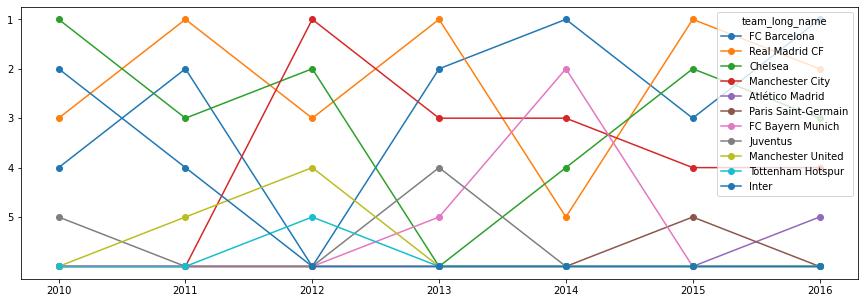

In [68]:
# Similarly, draw the line plot
df1_transposed.plot(kind='line',figsize=(15,5), marker='o')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.yticks(range(1,6))
ind = np.arange(7) 
plt.xticks(ind, ("2016","2015","2014","2013","2012","2011","2010"))
plt.show();

# 3, League Ranking (Finding best leagues each year)
We will consider the previous Player ranking results and Team ranking results to rank the league since a league is composed of teams and players.

In [69]:
def league_to_team(df_match,year):
    df_match = df_match.loc[:,["date","league_id","home_team_api_id","away_team_api_id"]]
    df_match['date'] = pd.to_datetime(df_match['date'])
    df_match = df_match[df_match['date'].dt.year == year]
    df_match = df_match.drop('date',axis=1)
    df_match=df_match.melt(['league_id'])
    df_match = df_match.drop('variable',axis=1)
    df_match.rename( columns={"value":"team_api_id" },inplace=True)
    df_match = df_match.drop_duplicates()
    return df_match

In [70]:
def top_leagues(df_comb_team,df_comb_player,df_match,season):
    year = int(season.split("/")[0])
    df_end_of_year_team = end_of_year_team(df_comb_team)
    df_end_of_year_player = end_of_year_player(df_comb_player,year)
    df_team_to_player = team_to_player(df_match,year)
    df_end_of_year_player = pd.merge(df_end_of_year_player, df_team_to_player, on="player_api_id")
    df_comb_player_team_group= df_end_of_year_player.sort_values('overall_rating').groupby('team_api_id').head(16)
    df_comb_player_team_group = df_comb_player_team_group.sort_values('overall_rating').groupby('team_api_id').sum()
    df_top = pd.merge(df_comb_player_team_group,df_end_of_year_team,on="team_api_id")
    df_top = df_top[["team_api_id","overall_rating","team_long_name"]]
    df_top = df_top.sort_values("overall_rating")
    df_top = df_top.sort_values("overall_rating",ascending=True)
    df_league_to_team = league_to_team(df_match,year)
    df_top = pd.merge(df_league_to_team,df_top,on="team_api_id")
    return df_top

In [71]:
# Season 2015/2016
df = top_leagues(df_comb_team,df_comb_player,df_match,season="2015/2016")
df = df.groupby("league_id").sum()
df.reset_index(level=0, inplace=True)
League.rename( columns={"id":"league_id" },inplace=True)
df = pd.merge(df,League,on="league_id")
df = df.sort_values("overall_rating", ascending=False)
df['rank1'] = range(1, len(df) + 1)
df_rank = df
df

,league_id,team_api_id,overall_rating,country_id,name,rank1
1,1729,211259,27031.0,1729,England Premier League,1
9,21518,207223,26963.0,21518,Spain LIGA BBVA,2
4,10257,410448,26102.0,10257,Italy Serie A,3
2,4769,205902,25195.0,4769,France Ligue 1,4
3,7809,181708,23075.0,7809,Germany 1. Bundesliga,5
5,13274,185965,22464.0,13274,Netherlands Eredivisie,6
7,17642,311550,19606.0,17642,Portugal Liga ZON Sagres,7
0,1,427067,18869.0,1,Belgium Jupiler League,8
6,15722,115904,16607.0,15722,Poland Ekstraklasa,9
8,19694,116853,12524.0,19694,Scotland Premier League,10


In [72]:
# Season 2014/2015
df = top_leagues(df_comb_team,df_comb_player,df_match,season="2014/2015")
df = df.groupby("league_id").sum()
df.reset_index(level=0, inplace=True)
League.rename( columns={"id":"league_id" },inplace=True)
df = pd.merge(df,League,on="league_id")
df = df.sort_values("overall_rating", ascending=False)
df['rank2'] = range(1, len(df) + 1)
df_rank = pd.merge(df_rank,df,on=["league_id","name"],how='outer')
df

,league_id,team_api_id,overall_rating,country_id,name,rank2
1,1729,210987,26449.0,1729,England Premier League,1
9,21518,207700,26236.0,21518,Spain LIGA BBVA,2
4,10257,208693,25573.0,10257,Italy Serie A,3
2,4769,209471,25071.0,4769,France Ligue 1,4
3,7809,183153,22673.0,7809,Germany 1. Bundesliga,5
5,13274,187658,22112.0,13274,Netherlands Eredivisie,6
7,17642,313583,20086.0,17642,Portugal Liga ZON Sagres,7
6,15722,123928,17198.0,15722,Poland Ekstraklasa,8
0,1,415297,16536.0,1,Belgium Jupiler League,9
8,19694,127104,13370.0,19694,Scotland Premier League,10


In [73]:
# Season 2013/2014
df = top_leagues(df_comb_team,df_comb_player,df_match,season="2013/2014")
df = df.groupby("league_id").sum()
df.reset_index(level=0, inplace=True)
League.rename( columns={"id":"league_id" },inplace=True)
df = pd.merge(df,League,on="league_id")
df = df.sort_values("overall_rating", ascending=False)
df['rank3'] = range(1, len(df) + 1)
df_rank = pd.merge(df_rank,df,on=["league_id","name"],how='outer')
df

,league_id,team_api_id,overall_rating,country_id,name,rank3
1,1729,212925,26565.0,1729,England Premier League,1
9,21518,208514,26123.0,21518,Spain LIGA BBVA,2
4,10257,208708,25869.0,10257,Italy Serie A,3
2,4769,211758,24878.0,4769,France Ligue 1,4
3,7809,182522,22658.0,7809,Germany 1. Bundesliga,5
5,13274,180648,20990.0,13274,Netherlands Eredivisie,6
7,17642,308634,19056.0,17642,Portugal Liga ZON Sagres,7
6,15722,118092,17313.0,15722,Poland Ekstraklasa,8
0,1,143906,16877.0,1,Belgium Jupiler League,9
8,19694,118675,12357.0,19694,Scotland Premier League,10


In [74]:
# Season 2012/2013
df = top_leagues(df_comb_team,df_comb_player,df_match,season="2012/2013")
df = df.groupby("league_id").sum()
df.reset_index(level=0, inplace=True)
League.rename( columns={"id":"league_id" },inplace=True)
df = pd.merge(df,League,on="league_id")
df = df.sort_values("overall_rating", ascending=False)
df['rank4'] = range(1, len(df) + 1)
df_rank = pd.merge(df_rank,df,on=["league_id","name"],how='outer')
df

,league_id,team_api_id,overall_rating,country_id,name,rank4
1,1729,211904,26415.0,1729,England Premier League,1
4,10257,208389,26282.0,10257,Italy Serie A,2
9,21518,206946,26254.0,21518,Spain LIGA BBVA,3
2,4769,208590,25134.0,4769,France Ligue 1,4
3,7809,189818,23923.0,7809,Germany 1. Bundesliga,5
5,13274,185171,21011.0,13274,Netherlands Eredivisie,6
0,1,163904,18422.0,1,Belgium Jupiler League,7
7,17642,150513,17943.0,17642,Portugal Liga ZON Sagres,8
6,15722,118309,16387.0,15722,Poland Ekstraklasa,9
8,19694,127254,13646.0,19694,Scotland Premier League,10


In [75]:
# Season 2011/2012
df = top_leagues(df_comb_team,df_comb_player,df_match,season="2011/2012")
df = df.groupby("league_id").sum()
df.reset_index(level=0, inplace=True)
League.rename( columns={"id":"league_id" },inplace=True)
df = pd.merge(df,League,on="league_id")
df = df.sort_values("overall_rating", ascending=False)
df['rank5'] = range(1, len(df) + 1)
df_rank = pd.merge(df_rank,df,on=["league_id","name"],how='outer')
df

,league_id,team_api_id,overall_rating,country_id,name,rank5
1,1729,210781,26538.0,1729,England Premier League,1
9,21518,206898,25940.0,21518,Spain LIGA BBVA,2
4,10257,208541,25935.0,10257,Italy Serie A,3
2,4769,308027,24979.0,4769,France Ligue 1,4
3,7809,181419,22620.0,7809,Germany 1. Bundesliga,5
5,13274,178758,19943.0,13274,Netherlands Eredivisie,6
0,1,161780,18267.0,1,Belgium Jupiler League,7
7,17642,144132,17057.0,17642,Portugal Liga ZON Sagres,8
6,15722,118611,14439.0,15722,Poland Ekstraklasa,9
8,19694,118750,12817.0,19694,Scotland Premier League,10


In [76]:
# Season 2010/2011
df = top_leagues(df_comb_team,df_comb_player,df_match,season="2010/2011")
df = df.groupby("league_id").sum()
df.reset_index(level=0, inplace=True)
League.rename( columns={"id":"league_id" },inplace=True)
df = pd.merge(df,League,on="league_id")
df = df.sort_values("overall_rating", ascending=False)
df['rank6'] = range(1, len(df) + 1)
df_rank = pd.merge(df_rank,df,on=["league_id","name"],how='outer')
df

,league_id,team_api_id,overall_rating,country_id,name,rank6
1,1729,206076,26645.0,1729,England Premier League,1
9,21518,212063,26233.0,21518,Spain LIGA BBVA,2
4,10257,210809,25932.0,10257,Italy Serie A,3
2,4769,308235,24809.0,4769,France Ligue 1,4
3,7809,182924,22623.0,7809,Germany 1. Bundesliga,5
5,13274,187372,21010.0,13274,Netherlands Eredivisie,6
7,17642,150596,18145.0,17642,Portugal Liga ZON Sagres,7
0,1,160008,16835.0,1,Belgium Jupiler League,8
8,19694,118889,12954.0,19694,Scotland Premier League,9
6,15722,118604,11943.0,15722,Poland Ekstraklasa,10


In [77]:
# Season 2009/2010
df = top_leagues(df_comb_team,df_comb_player,df_match,season="2009/2010")
df = df.groupby("league_id").sum()
df.reset_index(level=0, inplace=True)
League.rename( columns={"id":"league_id" },inplace=True)
df = pd.merge(df,League,on="league_id")
df = df.sort_values("overall_rating", ascending=False)
df['rank7'] = range(1, len(df) + 1)
df_rank = pd.merge(df_rank,df,on=["league_id","name"],how='outer')
df

,league_id,team_api_id,overall_rating,country_id,name,rank7
1,1729,206142,26581.0,1729,England Premier League,1
9,21518,210114,26212.0,21518,Spain LIGA BBVA,2
4,10257,209565,26079.0,10257,Italy Serie A,3
2,4769,210397,24790.0,4769,France Ligue 1,4
3,7809,193027,23432.0,7809,Germany 1. Bundesliga,5
5,13274,177154,19760.0,13274,Netherlands Eredivisie,6
7,17642,140385,17108.0,17642,Portugal Liga ZON Sagres,7
0,1,163662,16145.0,1,Belgium Jupiler League,8
8,19694,118889,13016.0,19694,Scotland Premier League,9
10,24558,105092,9683.0,24558,Switzerland Super League,10


In [78]:
df_rank = df_rank.replace(np.NaN,6)
df_rank.index = df_rank.name
df_rank = df_rank[[ 'rank1', 'rank2',
       'rank3', 'rank4', 'rank5', 'rank6','rank7']]
df1_transposed = df_rank.T

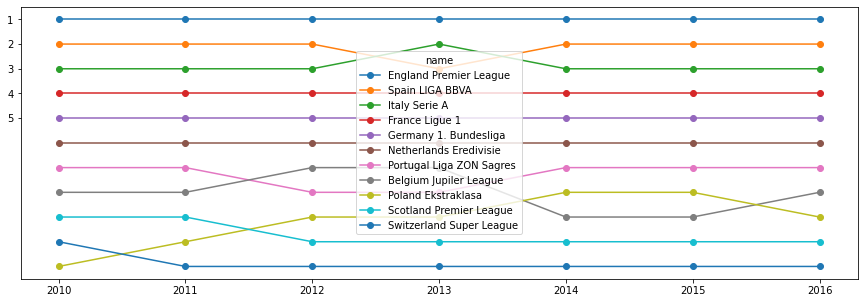

In [79]:
# Similarly, draw the line plot
df1_transposed.plot(kind='line',figsize=(15,5), marker='o')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.yticks(range(1,6))
ind = np.arange(7) 
plt.xticks(ind, ("2016","2015","2014","2013","2012","2011","2010"))
plt.show();

# 4, Match Outcome Prediction (Betting for return of investment)
Based on the match data, FIFA player statistics and bookkeeper data (betting odds from up to 10 providers retrieved from http://www.football-data.co.uk/notes.txt), we build models to predict the probability of each match outcome – win, draw, or defeat. Feature transformation and dimensionality reduction techniques are adopted so as to increase the quality of the feature space. We compare multiple classification algorithms and choose the one that performs best on a separate test dataset.   
It remains that football matches are affected by countless factors as well as a high degree of randomness, which makes it impossible to achieve perfect prediction accuracy. However, we prove that the model we build can predict match outcomes of European football matches more accurately than bookkeepers, thereby beating the odds and to, in the end, might generate a positive return on investment.

In [80]:
# Loading all functions we need
def get_match_label(match):
    ''' Derives a label for a given match. '''
    
    # Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id'] 

    # Identify match label  
    if home_goals > away_goals:
        label.loc[0,'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0,'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0,'label'] = "Defeat"

    # Return label        
    return label.loc[0]
    
def get_fifa_stats(match, player_stats):
    ''' Aggregates fifa stats for a given match. '''    
    
    # Define variables
    match_id =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    player_stats_new = pd.DataFrame()
    names = []
    
    # Loop through all players
    for player in players:   
            
        # Get player ID
        player_id = match[player]
        
        # Get player stats 
        stats = player_stats[player_stats.player_api_id == player_id]
            
        # Identify current stats       
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        # Rename stat
        name = "{}_overall_rating".format(player)
        names.append(name)
            
        # Aggregate stats
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id

    player_stats_new.reset_index(inplace = True, drop = True)
    
    # Return player stats    
    return player_stats_new.iloc[0]     
      
def get_fifa_data(matches, player_stats, path = None, data_exists = False):
    ''' Gets fifa data for all matches. '''  
    
    # Check if fifa data already exists
    if data_exists == True:
        
        fifa_data = pd.read_pickle(path)
        
    else:
        
        print("Collecting fifa data for each match...")       
        start = time()
        
        # Apply get_fifa_stats for each match
        fifa_data = matches.apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
        
        end = time()    
        print("Fifa data collected in {:.1f} minutes".format((end - start)/60))
    
    # Return fifa_data
    return fifa_data

def get_overall_fifa_rankings(fifa, get_overall = False):
    ''' Get overall fifa rankings from fifa data. '''
      
    temp_data = fifa
    
    # Check if only overall player stats are desired
    if get_overall == True:
        
        # Get overall stats
        data = temp_data.loc[:,(fifa.columns.str.contains('overall_rating'))]
        data.loc[:,'match_api_id'] = temp_data.loc[:,'match_api_id']
    else:
        
        # Get all stats except for stat date
        cols = fifa.loc[:,(fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis = 1)        
        data = temp_data
    
    # Return data
    return data

def get_last_matches(matches, date, team, x = 10):
    ''' Get the last x matches of a given team. '''
    
    # Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
    # Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    # Return last matches
    return last_matches
    
def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    ''' Get the last x matches of two given teams. '''
    
    # Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    # Get last x matches
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        # Check for error in data
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
            
    # Return data
    return last_matches
    
def get_goals(matches, team):
    ''' Get the goals of a specfic team from a set of matches. '''
    
    # Find home and away goals
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals
    
    # Return total goals
    return total_goals

def get_goals_conceided(matches, team):
    ''' Get the goals conceided of a specfic team from a set of matches. '''

    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    # Return total goals
    return total_goals

def get_wins(matches, team):
    ''' Get the number of wins of a specfic team from a set of matches. '''
    
    # Find home and away wins
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    # Return total wins
    return total_wins      
    
def get_match_features(match, matches, x = 10):
    ''' Create match specific features for a given match. '''
    
    # Define variables
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
    # Get last x matches of home and away team
    matches_home_team = get_last_matches(matches, date, home_team, x = 10)
    matches_away_team = get_last_matches(matches, date, away_team, x = 10)
    
    # Get last x matches of both teams against each other
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    
    # Create goal variables
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    
    # Define result data frame
    result = pd.DataFrame()
    
    # Define ID features
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id

    # Create match features
    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team) 
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)
    
    # Return match features
    return result.loc[0]
    
def create_feables(matches, fifa, bookkeepers, get_overall = False, horizontal = True, x = 10, verbose = True):
    ''' Create and aggregate features and labels for all matches. '''

    # Get fifa stats features
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)
    
    
    if verbose == True:
        print("Generating match features...")
    start = time()
    
    # Get match features for all matches
    match_stats = matches.apply(lambda x: get_match_features(x, matches, x = 10), axis = 1)
     
    # Create dummies for league ID feature
    dummies = pd.get_dummies(match_stats['league_id']).rename(columns = lambda x: 'League_' + str(x))
    match_stats = pd.concat([match_stats, dummies], axis = 1)
    match_stats.drop(['league_id'], inplace = True, axis = 1)
    
    end = time()
    if verbose == True:
        print("Match features generated in {:.1f} minutes".format((end - start)/60))
    
    if verbose == True:    
        print("Generating match labels...")
    start = time()
    
    # Create match labels
    labels = matches.apply(get_match_label, axis = 1)
    end = time()
    if verbose == True:
        print("Match labels generated in {:.1f} minutes".format((end - start)/60))
    
    if verbose == True:    
        print("Generating bookkeeper data...")
    start = time()
    
    # Get bookkeeper quotas for all matches
    bk_data = get_bookkeeper_data(matches, bookkeepers, horizontal = True)
    bk_data.loc[:,'match_api_id'] = matches.loc[:,'match_api_id']
    end = time()
    if verbose == True:
        print("Bookkeeper data generated in {:.1f} minutes".format((end - start)/60))

    # Merges features and labels into one frame
    features = pd.merge(match_stats, fifa_stats, on = 'match_api_id', how = 'left')
    features = pd.merge(features, bk_data, on = 'match_api_id', how = 'left')
    feables = pd.merge(features, labels, on = 'match_api_id', how = 'left')
    
    # Drop NA values
    feables.dropna(inplace = True)
    
    # Return preprocessed data
    return feables
    
def train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs, use_grid_search = True, 
                     best_components = None, best_params = None):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    
    # Check if grid search should be applied
    if use_grid_search == True: 
        
        # Define pipeline of dm reduction and classifier
        estimators = [('dm_reduce', dm_reduction), ('clf', clf)]
        pipeline = Pipeline(estimators)
        
        # Grid search over pipeline and return best classifier
        params['dm_reduce__n_components'] = params['dm_reduce__n_components'].astype(int)
        grid_obj = model_selection.GridSearchCV(pipeline, param_grid = params, scoring = scorer, cv = cv_sets, n_jobs = jobs)
        grid_obj.fit(X_train, y_train)
        best_pipe = grid_obj.best_estimator_
    else:
        
        # Use best components that are known without grid search        
        estimators = [('dm_reduce', dm_reduction(n_components = best_components)), ('clf', clf(best_params))]
        pipeline = Pipeline(estimators)        
        best_pipe = pipeline.fit(X_train, y_train)
        
    end = time()
    
    # Print the results
    print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    # Return best pipe
    return best_pipe
    
def predict_labels(clf, best_pipe, features, target):
    ''' Makes predictions using a fit classifier based on scorer. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(best_pipe.named_steps['dm_reduce'].transform(features))
    end = time()
    
    # Print and return results
    print("Made predictions in {:.4f} seconds".format(end - start))
    return accuracy_score(target.values, y_pred)
    
def train_calibrate_predict(clf, dm_reduction, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test, cv_sets, params, scorer, jobs, 
                            use_grid_search = True, **kwargs):
    ''' Train and predict using a classifer based on scorer. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} with {}...".format(clf.__class__.__name__, dm_reduction.__class__.__name__))
    
    # Train the classifier
    best_pipe = train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs)
    
    # Calibrate classifier
    print("Calibrating probabilities of classifier...")
    start = time()    
    clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
    clf.fit(best_pipe.named_steps['dm_reduce'].transform(X_calibrate), y_calibrate)
    end = time()
    print("Calibrated {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    # Print the results of prediction for both training and testing
    print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_train, y_train)))
    print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_test, y_test)))
    
    # Return classifier, dm reduction, and label predictions for train and test set
    return clf, best_pipe.named_steps['dm_reduce'], predict_labels(clf, best_pipe, X_train, y_train), predict_labels(clf, best_pipe, X_test, y_test)
        
def convert_odds_to_prob(match_odds):
    ''' Converts bookkeeper odds to probabilities. '''
    
    # Define variables
    match_id = match_odds.loc[:,'match_api_id']
    bookkeeper = match_odds.loc[:,'bookkeeper']    
    win_odd = match_odds.loc[:,'Win']
    draw_odd = match_odds.loc[:,'Draw']
    loss_odd = match_odds.loc[:,'Defeat']
    
    # Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    # Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'bookkeeper'] = bookkeeper
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    probs.loc[:,'Defeat'] = loss_prob / total_prob
    
    # Return probs and meta data
    return probs
    
def get_bookkeeper_data(matches, bookkeepers, horizontal = True):
    ''' Aggregates bookkeeper data for all matches and bookkeepers. '''
    
    bk_data = pd.DataFrame()
    
    # Loop through bookkeepers
    for bookkeeper in bookkeepers:

        # Find columns containing data of bookkeeper
        temp_data = matches.loc[:,(matches.columns.str.contains(bookkeeper))]
        temp_data.loc[:, 'bookkeeper'] = str(bookkeeper)
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
        
        # Rename odds columns and convert to numeric
        cols = temp_data.columns.values
        cols[:3] = ['Win','Draw','Defeat']
        temp_data.columns = cols
        temp_data.loc[:,'Win'] = pd.to_numeric(temp_data['Win'])
        temp_data.loc[:,'Draw'] = pd.to_numeric(temp_data['Draw'])
        temp_data.loc[:,'Defeat'] = pd.to_numeric(temp_data['Defeat'])
        
        # Check if data should be aggregated horizontally
        if(horizontal == True):
            
            # Convert data to probs
            temp_data = convert_odds_to_prob(temp_data)
            temp_data.drop('match_api_id', axis = 1, inplace = True)
            temp_data.drop('bookkeeper', axis = 1, inplace = True)
            
            # Rename columns with bookkeeper names
            win_name = bookkeeper + "_" + "Win"
            draw_name = bookkeeper + "_" + "Draw"
            defeat_name = bookkeeper + "_" + "Defeat"
            temp_data.columns.values[:3] = [win_name, draw_name, defeat_name]

            # Aggregate data
            bk_data = pd.concat([bk_data, temp_data], axis = 1)
        else:
            # Aggregate vertically
            bk_data = bk_data.append(temp_data, ignore_index = True)
    
    # If horizontal add match api id to data
    if(horizontal == True):
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
    
    # Return bookkeeper data
    return bk_data
    
def get_bookkeeper_probs(matches, bookkeepers, horizontal = False):
    ''' Get bookkeeper data and convert to probabilities for vertical aggregation. '''
    
    # Get bookkeeper data
    data = get_bookkeeper_data(matches, bookkeepers, horizontal = False)
    
    # Convert odds to probabilities
    probs = convert_odds_to_prob(data)
    
    # Return data
    return probs

def plot_confusion_matrix(y_test, X_test, clf, dim_reduce, path, cmap=plt.cm.Blues, normalize = False):    
    ''' Plot confusion matrix for given classifier and data. '''
    
    # Define label names and get confusion matrix values
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, clf.predict(dim_reduce.transform(X_test)), labels)
    
    # Check if matrix should be normalized
    if normalize == True:
        
        # Normalize
        cm = cm.astype('float') / cm.sum()
        
    # Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title= "Confusion matrix of a {} with {}".format(best_clf.base_estimator.__class__.__name__, best_dm_reduce.__class__.__name__)   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    # Print classification report
    y_pred = clf.predict(dim_reduce.transform(X_test))
    print(classification_report(y_test, y_pred)) 

def compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False):
    ''' Map bookkeeper and model probabilities. '''
    
    # Create features and labels for given matches
    feables = create_feables(matches, fifa_data, bk, get_overall = True, verbose = False)
    
    # Ensure consistency
    match_ids = list(feables['match_api_id'])
    matches = matches[matches['match_api_id'].isin(match_ids)]
    
    # Get bookkeeper probabilities
    if verbose == True:
        print("Obtaining bookkeeper probabilities...")
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    
    inputs = feables.drop('match_api_id', axis = 1)
    labels = inputs.loc[:,'label']
    features = inputs.drop('label', axis = 1)
    
    # Get model probabilities
    if verbose == True:
        print("Predicting probabilities based on model...")
    model_probs = pd.DataFrame()
    label_table = pd.Series()
    temp_probs = pd.DataFrame(clf.predict_proba(dim_reduce.transform(features)), columns = ['win_prob', 'draw_prob', 'defeat_prob'])
    for bookkeeper in bookkeepers:
        model_probs = model_probs.append(temp_probs, ignore_index = True)
        label_table = label_table.append(labels)
    model_probs.reset_index(inplace = True, drop = True)
    label_table.reset_index(inplace = True, drop = True)
    bookkeeper_probs['win_prob'] = model_probs['win_prob']
    bookkeeper_probs['draw_prob'] = model_probs['draw_prob']
    bookkeeper_probs['defeat_prob'] = model_probs['defeat_prob']
    bookkeeper_probs['label'] = label_table 
    
    # Aggregate win probabilities for each match
    wins = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Win', 'win_prob', 'label']]
    wins.loc[:, 'bet'] = 'Win'
    wins = wins.rename(columns = {'Win':'bookkeeper_prob',
                                  'win_prob': 'model_prob'})
                                  
    # Aggregate draw probabilities for each match
    draws = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Draw', 'draw_prob', 'label']]
    draws.loc[:, 'bet'] = 'Draw'
    draws = draws.rename(columns = {'Draw':'bookkeeper_prob',
                                  'draw_prob': 'model_prob'})
                                  
    # Aggregate defeat probabilities for each match
    defeats = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Defeat', 'defeat_prob', 'label']]
    defeats.loc[:, 'bet'] = 'Defeat'
    defeats = defeats.rename(columns = {'Defeat':'bookkeeper_prob',
                                  'defeat_prob': 'model_prob'})
    
    total = pd.concat([wins, draws, defeats])
    
    # Return total
    return total
    
def find_good_bets(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, percentile, prob_cap, verbose = False):
    ''' Find good bets for a given classifier and matches. '''
    
    # Compare model and classifier probabilities
    probs = compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False)
    probs.loc[:, 'prob_difference'] = probs.loc[:,"model_prob"] - probs.loc[:,"bookkeeper_prob"]
    
    # Sort by createst difference to identify most underestimated bets    
    values = probs['prob_difference']
    values = values.sort_values(ascending = False)
    values.reset_index(inplace = True, drop = True)
    
    if verbose == True:
        print("Selecting attractive bets...")
        
    # Identify choices that fulfill requirements such as positive difference, minimum probability and match outcome
    relevant_choices = probs[(probs.prob_difference > 0) & (probs.model_prob > prob_cap) & (probs.bet != "Draw")]
    
    # Select given percentile of relevant choices    
    top_percent = 1 - percentile
    choices = relevant_choices[relevant_choices.prob_difference >= relevant_choices.prob_difference.quantile(top_percent)]
    choices.reset_index(inplace = True, drop = True)
    
    # Return choices
    return choices

def get_reward(choice, matches):
    ''' Get the reward of a given bet. '''
    
    # Identify bet
    match = matches[matches.match_api_id == choice.match_api_id]
    bet_data = match.loc[:,(match.columns.str.contains(choice.bookkeeper))]
    cols = bet_data.columns.values
    cols[:3] = ['win','draw','defeat']
    bet_data.columns = cols
    
    # Identfiy bet type and get quota
    if choice.bet == 'Win':
        bet_quota = bet_data.win.values
    elif choice.bet == 'Draw':
        bet_quota = bet_data.draw.values
    elif choice.bet == 'Defeat':
        bet_quota = bet_data.defeat.values
    else:
        print("Error")
    
    # Check label and compute reward
    if choice.bet == choice.label:
        reward = bet_quota
    else:
        reward = 0
    
    # Return reward
    return reward
      
def execute_bets(bet_choices, matches, verbose = False):
    ''' Get rewards for all bets. '''    
    
    if verbose == True:
        print("Obtaining reward for chosen bets...")
    total_reward = 0
    total_invested = 0
    
    # Loop through bets
    loops = np.arange(0, bet_choices.shape[0])     
    for i in loops:
        
        # Get rewards and accumulate profit
        reward = get_reward(bet_choices.iloc[i,:], matches)
        total_reward = total_reward + reward
        total_invested += 1
    
    # Compute investment return
    investment_return = float(total_reward / total_invested) - 1
    
    # Return investment return
    return investment_return
    
def explore_data(features, inputs, path):
    ''' Explore data by plotting KDE graphs. '''
    
    # Define figure subplots
    fig = plt.figure(1)
    fig.subplots_adjust(bottom= -1, left=0.025, top = 2, right=0.975)
    
    # Loop through features    
    i = 1
    for col in features.columns:
        
        # Set subplot and plot format        
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale = 0.5, rc={"lines.linewidth": 1})
        plt.subplot(7,7,0 + i)
        j = i - 1
        
        # Plot KDE for all labels
        sns.distplot(inputs[inputs['label'] == 'Win'].iloc[:,j], hist = False, label = 'Win')
        sns.distplot(inputs[inputs['label'] == 'Draw'].iloc[:,j], hist = False, label = 'Draw')
        sns.distplot(inputs[inputs['label'] == 'Defeat'].iloc[:,j], hist = False, label = 'Defeat')
        plt.legend();
        i = i + 1
    
    # Define plot format    
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches((DefaultSize[0]*2, DefaultSize[1]*2))

    plt.show()
    
    # Compute and print label weights
    labels = inputs.loc[:,'label']
    class_weights = labels.value_counts() / len(labels)
    print(class_weights)
    
    # Store description of all features
    feature_details = features.describe().transpose()

    # Return feature details
    return feature_details
    
def find_best_classifier(classifiers, dm_reductions, scorer, X_t, y_t, X_c, y_c, X_v, y_v, cv_sets, params, jobs):
    ''' Tune all classifier and dimensionality reduction combiantions to find best classifier. '''
    
    # Initialize result storage
    clfs_return = []
    dm_reduce_return = []
    train_scores = []
    test_scores = []
    
    # Loop through dimensionality reductions
    for dm in dm_reductions:
        
        # Loop through classifiers
        for clf in clfs:
            
            # Grid search, calibrate, and test the classifier
            clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = clf, dm_reduction = dm, X_train = X_t, y_train = y_t,
                                                      X_calibrate = X_c, y_calibrate = y_c,
                                                      X_test = X_v, y_test = y_v, cv_sets = cv_sets,
                                                      params = params[clf], scorer = scorer, jobs = jobs, use_grid_search = True)
            
            # Append the result to storage            
            clfs_return.append(clf)
            dm_reduce_return.append(dm_reduce)
            train_scores.append(train_score)
            test_scores.append(test_score)
    
    # Return storage
    return clfs_return, dm_reduce_return, train_scores, test_scores

def plot_training_results(clfs, dm_reductions, train_scores, test_scores, path):
    ''' Plot results of classifier training. '''
    
    # Set graph format
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale = 1, rc={"lines.linewidth": 1})
    ax = plt.subplot(111)
    w = 0.5
    x = np.arange(len(train_scores))
    ax.set_yticks(x + w)
    ax.legend((train_scores[0], test_scores[0]), ("Train Scores", "Test Scores"))
    names = []
    
    # Loop throuugh classifiers
    for i in range(0, len(clfs)): 
        
        # Define temporary variables        
        clf = clfs[i]
        clf_name = clf.base_estimator.__class__.__name__
        dm = dm_reductions[i]
        dm_name = dm.__class__.__name__
        
        # Create and store name
        name = "{} with {}".format(clf_name, dm_name)
        names.append(name)
        
    # Plot all names in horizontal bar plot
    ax.set_yticklabels((names))
    plt.xlim(0.5, 0.55)
    plt.barh(x, test_scores, color = 'b', alpha = 0.6)
    plt.title("Test Data Accuracy Scores")
    fig = plt.figure(1)
    
    plt.show()
    
def optimize_betting(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, match_data, fifa_data,
                     n_samples, sample_size, parameter_1_grid, parameter_2_grid, verbose = False):
    ''' Tune parameters of bet selection algorithm. '''
    
    # Generate data samples
    samples = []
    for i in range(0, n_samples):
        sample = match_data.sample(n = sample_size, random_state = 42)
        samples.append(sample)
    
    results = pd.DataFrame(columns = ["parameter_1", "parameter_2", "results"])
    row = 0
    
    # Iterate over all 1 parameter
    for i in parameter_1_grid:
        
        # Iterate over all 2 parameter
        for j in parameter_2_grid:
            
            # Compute average score over all samples
            profits = []
            for sample in samples:
                choices = find_good_bets(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, sample, fifa_data, i, j)
                profit = execute_bets(choices, match_data)
                profits.append(profit)
            result = np.mean(np.array(profits))
            results.loc[row,"results"] = result
            results.loc[row,"parameter_1"] = i
            results.loc[row,"parameter_2"] = j
            row = row + 1
            if verbose == True: print("Simulated parameter combination: {}".format(row))
               
    # Return best setting and result
    best_result = results.iloc[results['results'].idxmax()] 
    return best_result
    
    
def plot_bookkeeper_cf_matrix(matches, bookkeepers, path, verbose = False, normalize = True):
    ''' Plot confusion matrix of bookkeeper predictions. '''
    
    if verbose == True: print("Obtaining labels...")
    
    # Get match labels
    y_test_temp = matches.apply(get_match_label, axis = 1)
    
    if verbose == True: print("Obtaining bookkeeper probabilities...")
    
    # Get bookkeeper probabilities
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    bookkeeper_probs.dropna(inplace = True)
    
    if verbose == True: print("Obtaining bookkeeper labels...")
    
    # Get bookkeeper labels
    y_pred_temp = pd.DataFrame()
    y_pred_temp.loc[:,'bk_label'] = bookkeeper_probs[['Win', 'Draw', 'Defeat']].idxmax(axis = 1)
    y_pred_temp.loc[:,'match_api_id'] = bookkeeper_probs.loc[:, 'match_api_id']
    
    if verbose == True: print("Plotting confusion matrix...")
    
    # Format data
    results = pd.merge(y_pred_temp, y_test_temp, on = 'match_api_id', how = 'left')
    y_test = results.loc[:, 'label']
    y_pred = results.loc[:, 'bk_label']
    
    # Generate confusion matrix
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, y_pred, labels) 
    
    # Check for normalization
    if normalize == True:
        cm = cm.astype('float') / cm.sum()
        
    # Plot confusion matrix
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title = "Confusion matrix of Bookkeeper predictions!"   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    # Print classification report and accuracy score of bookkeepers
    print(classification_report(y_test, y_pred)) 
    print("Bookkeeper score for test set: {:.4f}.".format(accuracy_score(y_test, y_pred)))

In [81]:
start = time()
# Fetching data
# Connecting to database
path = ""  # Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

# Defining the number of jobs to be run in parallel during grid search
n_jobs = 1 # Insert number of parallel jobs here

# Fetching required data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

# Reduce match data to fulfill run time requirements
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data.dropna(subset = rows, inplace = True)
match_data = match_data.tail(1500)

In [82]:
# Generating features, exploring the data, and preparing data for model training
# Generating or retrieving already existant FIFA data
fifa_data = get_fifa_data(match_data, player_stats_data, data_exists = False)

# Creating features and labels based on data provided
bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bk_cols_selected = ['B365', 'BW']      
feables = create_feables(match_data, fifa_data, bk_cols_selected, get_overall = True)
inputs = feables.drop('match_api_id', axis = 1)

Fifa data collected in 2.0 minutes
Generating match features...
Match features generated in 0.5 minutes
Generating match labels...
Match labels generated in 0.0 minutes
Generating bookkeeper data...
Bookkeeper data generated in 0.0 minutes


No handles with labels found to put in legend.
No handles with labels found to put in legend.


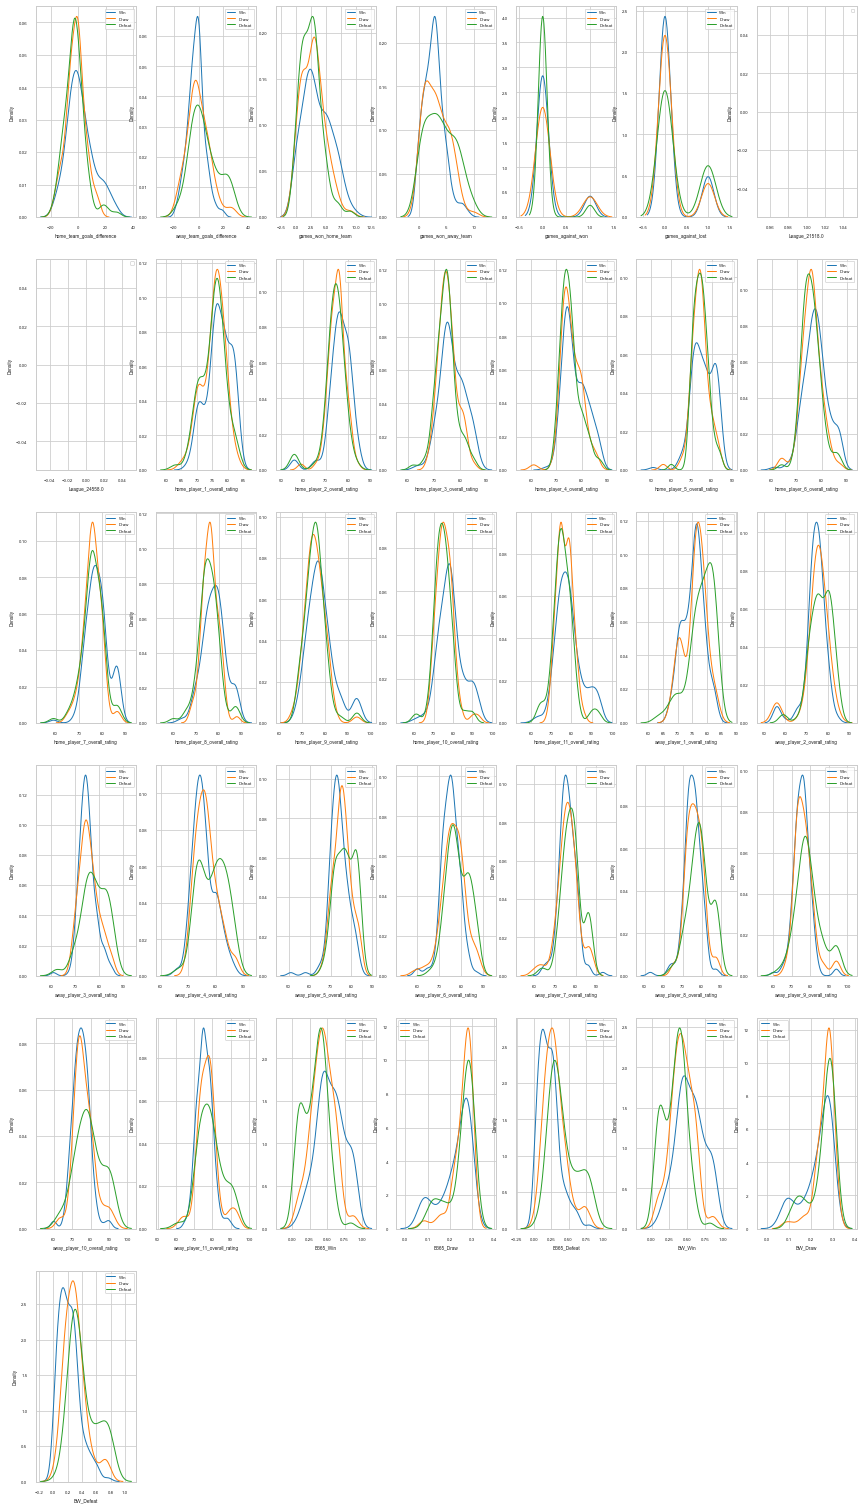

Win       0.481366
Defeat    0.279503
Draw      0.239130
Name: label, dtype: float64


,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,League_21518.0,League_24558.0,home_player_1_overall_rating,home_player_2_overall_rating,...,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,B365_Win,B365_Draw,B365_Defeat,BW_Win,BW_Draw,BW_Defeat
0,-5.0,-8.0,2.0,1.0,0.0,0.0,1,0,77.0,69.0,...,72.0,71.0,73.0,73.0,0.395683,0.287770,0.316547,0.389704,0.287782,0.322514
1,4.0,-2.0,4.0,1.0,0.0,0.0,1,0,76.0,79.0,...,74.0,76.0,71.0,72.0,0.624582,0.238903,0.136516,0.612713,0.253365,0.133922
2,18.0,7.0,6.0,6.0,0.0,0.0,1,0,81.0,81.0,...,88.0,78.0,90.0,88.0,0.390698,0.260465,0.348837,0.380496,0.279776,0.339728
3,1.0,1.0,2.0,3.0,0.0,0.0,1,0,79.0,65.0,...,79.0,81.0,81.0,79.0,0.360875,0.287606,0.351519,0.354839,0.290323,0.354839
4,1.0,1.0,3.0,1.0,0.0,0.0,1,0,74.0,73.0,...,69.0,67.0,76.0,76.0,0.651526,0.223380,0.125093,0.634855,0.224066,0.141079


In [83]:
# Exploring the data and creating visualizations
labels = inputs.loc[:,'label']
features = inputs.drop('label', axis = 1)
feature_details = explore_data(features, inputs, path)
features.head(5)

In [84]:
# Splitting the data into Train, Calibrate, and Test data sets
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42, 
                                                                        stratify = labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.3, random_state = 42, 
                                                              stratify = y_train_calibrate)

# Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

5

In [85]:
# Initializing all models and parameters
# Initializing classifiers
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')
AB_clf = AdaBoostClassifier(n_estimators = 200, random_state = 2)
GNB_clf = GaussianNB()
KNN_clf =  KNeighborsClassifier()
LOG_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced')
clfs = [RF_clf, AB_clf, GNB_clf, KNN_clf, LOG_clf]

# Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'], 
                 'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5))}
parameters_AB = {'clf__learning_rate': np.linspace(0.5, 2, 5), 
                 'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5))}
parameters_GNB = {'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5))}
parameters_KNN = {'clf__n_neighbors': [3, 5, 10], 
                  'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5))}
parameters_LOG = {'clf__C': np.logspace(1, 1000, 5), 
                  'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5))}

parameters = {clfs[0]: parameters_RF,
              clfs[1]: parameters_AB,
              clfs[2]: parameters_GNB,
              clfs[3]: parameters_KNN,
              clfs[4]: parameters_LOG}

# Initializing dimensionality reductions
pca = PCA()
dm_reductions = [pca]  

Score of LogisticRegression for training set: 0.6089.
Score of LogisticRegression for test set: 0.5077.
Training a RandomForestClassifier with PCA...
Trained RandomForestClassifier in 0.3 minutes
Calibrating probabilities of classifier...
Calibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 0.0229 seconds
Score of CalibratedClassifierCV for training set: 0.9106.
Made predictions in 0.0189 seconds
Score of CalibratedClassifierCV for test set: 0.5077.
Made predictions in 0.0239 seconds
Made predictions in 0.0180 seconds
Training a AdaBoostClassifier with PCA...
Trained AdaBoostClassifier in 0.8 minutes
Calibrating probabilities of classifier...
Calibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 0.0439 seconds
Score of CalibratedClassifierCV for training set: 0.6034.
Made predictions in 0.0339 seconds
Score of CalibratedClassifierCV for test set: 0.5385.
Made predictions in 0.0409 seconds
Made predictions in 0.0319 seconds
Training a GaussianNB with PCA..

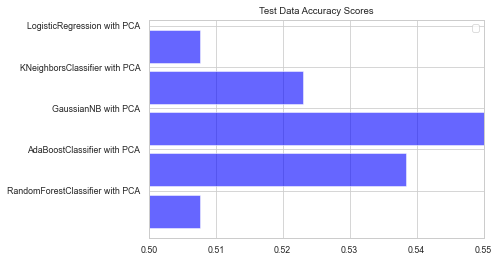

In [86]:
# Training a baseline model and finding the best model composition using grid search
# Train a simple GBC classifier as baseline model
clf = LOG_clf
clf.fit(X_train, y_train)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, clf.predict(X_test))))

# Training all classifiers and comparing them
clfs, dm_reductions, train_scores, test_scores = find_best_classifier(clfs, dm_reductions, scorer, X_train, y_train, 
                                                                    X_calibrate, y_calibrate, X_test, y_test, cv_sets, 
                                                                      parameters, n_jobs)

# Plotting train and test scores
plot_training_results(clfs, dm_reductions, np.array(train_scores), np.array(test_scores), path = path)

The best classifier is a GaussianNB with PCA.


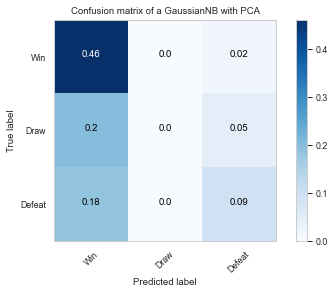

              precision    recall  f1-score   support

      Defeat       0.60      0.33      0.43        18
        Draw       0.00      0.00      0.00        16
         Win       0.55      0.97      0.70        31

    accuracy                           0.55        65
   macro avg       0.38      0.43      0.38        65
weighted avg       0.43      0.55      0.45        65

Obtaining labels...
Obtaining bookkeeper probabilities...
Obtaining bookkeeper labels...
Plotting confusion matrix...


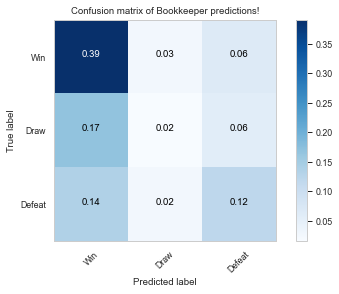

              precision    recall  f1-score   support

      Defeat       0.50      0.43      0.46       630
        Draw       0.23      0.06      0.10       539
         Win       0.56      0.81      0.67      1085

    accuracy                           0.53      2254
   macro avg       0.43      0.43      0.41      2254
weighted avg       0.47      0.53      0.47      2254

Bookkeeper score for test set: 0.5262.


In [87]:
# Plotting a confusion matrix of the best model and the bookkeeper predictions
# Defining the best classifier and plotting a confusion matrix
best_clf = clfs[np.argmax(test_scores)]
best_dm_reduce = dm_reductions[np.argmax(test_scores)]
print("The best classifier is a {} with {}.".format(best_clf.base_estimator.__class__.__name__, best_dm_reduce.__class__.__name__)                              )
plot_confusion_matrix(y_test, X_test, best_clf, best_dm_reduce, path = path, normalize = True)

#Plotting a confusion matrix of bookkeepers
plot_bookkeeper_cf_matrix(match_data, bk_cols, path, verbose = True, normalize = True)

As you may find out, our best classifier GaussianNB achieved accuracy on test setof  0.5538, higher than the bookkeeper accuracy of 0.5262.